In [103]:
import pandas as pd
import numpy as np
import requests
import tarfile
import regex as re
import string
import spacy
import torch

from wordcloud import WordCloud
from textwrap import wrap
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

import nltk
import json
from collections import Counter

In [104]:
#check if MovieSummaries.tar.gz exists, download and decompress
try:
    open('MovieSummaries.tar.gz')
except FileNotFoundError:
    print("Downloading MovieSummaries.tar.gz, decompressing, and saving to ./Data")
    url = 'http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz'
    r = requests.get(url)
    with open('MovieSummaries.tar.gz', 'wb') as f:
        f.write(r.content)
    # decompress downloaded data
    with tarfile.open('MovieSummaries.tar.gz') as f:
        f.extractall('./Data')
        

# Data

## plot_summaries.txt.gz [29 M] 

Plot summaries of 42,306 movies extracted from the November 2, 2012 dump of English-language Wikipedia.  Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the summary.


# Metadata

## movie.metadata.tsv.gz [3.4 M]

Metadata for 81,741 movies, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)

## character.metadata.tsv.gz [14 M]

Metadata for 450,669 characters aligned to the movies above, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie release date
4. Character name
5. Actor date of birth
6. Actor gender
7. Actor height (in meters)
8. Actor ethnicity (Freebase ID)
9. Actor name
10. Actor age at movie release
11. Freebase character/actor map ID
12. Freebase character ID
13. Freebase actor ID


# Test data

## tvtropes.clusters.txt

72 character types drawn from tvtropes.com, along with 501 instances of those types.  The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.

## name.clusters.txt


970 unique character names used in at least two different movies, along with 2,666 instances of those types.  The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.



In [105]:
# read data
# some files are saved as .txt but all files are in tsv-format (tab separated)
df_character_metadata = pd.read_csv('Data/MovieSummaries/character.metadata.tsv', delimiter='\t', header=None)
df_movie_metadata = pd.read_csv('Data/MovieSummaries/movie.metadata.tsv', delimiter='\t', header=None)
df_name_cluster = pd.read_csv('Data/MovieSummaries/name.clusters.txt', delimiter='\t', header=None)
df_plot_summary = pd.read_csv('Data/MovieSummaries/plot_summaries.txt', delimiter='\t', header=None)
df_tvtrope_cluster = pd.read_csv('Data/MovieSummaries/tvtropes.clusters.txt', delimiter='\t', header=None)

In [106]:
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r'\w*\d\w*', '', text)
    # Remove punctuation
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    # Remove extra spaces
    text = re.sub(r' +', ' ', text)
    #remove leading and trailing spaces
    text = text.strip()
    return text

In [107]:
# try if cuda is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(torch.cuda.get_device_name(0))
    import spacy_transformers
    spacy.require_gpu() #or spacy.prefer_gpu()
else:
    device = torch.device('cpu')  


In [108]:
#test if spacy en_core_web_xx exists, if not download it
#English pipeline optimized for CPU. Components: tok2vec, tagger, parser, senter, ner, attribute_ruler, lemmatizer.
#https://spacy.io/models/en

try:
    lemmatizer = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
except:
    print('Downloading en_core_web_sm')
    !python -m spacy download en_core_web_sm
    lemmatizer = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    

In [109]:
#if plot_summaries.csv exists, read it, else create it
try:
    df_plot_summary = pd.read_csv('Data/MovieSummaries/plot_summaries_trf.csv').iloc[: , 1:]
except FileNotFoundError:
    print('Creating plot_summaries.csv')
    # preprocess the text
    df_plot_summary[1] = df_plot_summary[1].apply(preprocess_text)
    # Lemmatization with stopwords removal
    df_plot_summary[1] = df_plot_summary[1].apply(lambda x: ' '.join([token.lemma_ for token in list(lemmatizer(x)) if (token.is_stop==False)]))
    # save the preprocessed data
    df_plot_summary.to_csv('Data/MovieSummaries/plot_summaries.csv')

## EDA

In [110]:
df_plot_summary.head()

,0,1
0,23890098,shlykov hardworking taxi driver lyosha saxopho...
1,31186339,nation panem consist wealthy capitol poor dist...
2,20663735,poovalli induchoodan sentence year prison life...
3,2231378,lemon drop kid new york city swindler illegall...
4,595909,seventhday adventist church pastor michael cha...


In [111]:
df_plot_summary

,0,1
0,23890098,shlykov hardworking taxi driver lyosha saxopho...
1,31186339,nation panem consist wealthy capitol poor dist...
2,20663735,poovalli induchoodan sentence year prison life...
3,2231378,lemon drop kid new york city swindler illegall...
4,595909,seventhday adventist church pastor michael cha...
...,...,...
42298,34808485,story reema young muslim schoolgirl malabar lo...
42299,1096473,hollywood director leo andreyev look photograp...
42300,35102018,american luthier focus randy parson ’ transfor...
42301,8628195,abdur rehman khan middleage dry fruit seller a...


In [112]:
# create document term matrix
cv = CountVectorizer(analyzer='word')
data = cv.fit_transform(df_plot_summary['1'])  # returns sparse DTM

In [113]:
# Extract one row (film) from the DTM and expand to all rows (sparse -> dense)
df_dtm = pd.DataFrame(data.getrow(1).toarray(), columns=cv.get_feature_names_out())

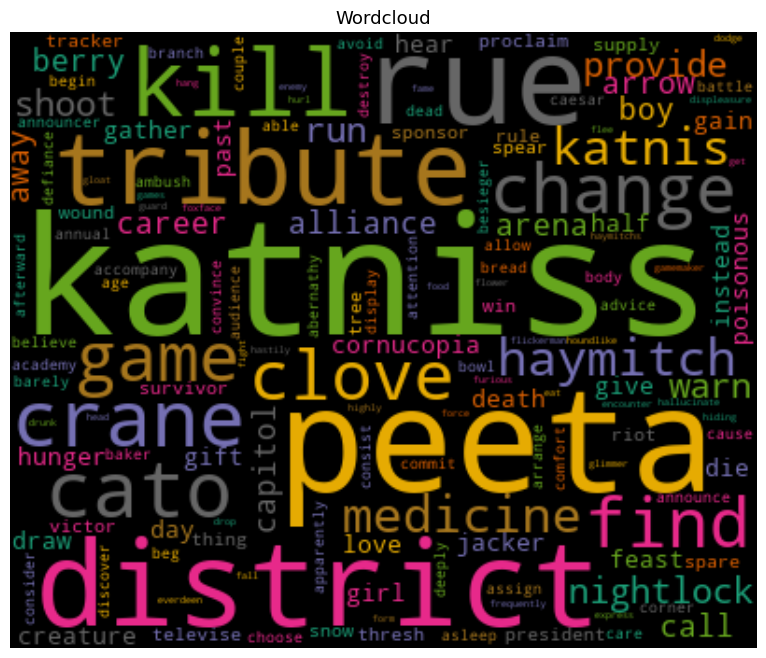

In [114]:
# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text


# Function for generating word clouds
def generate_wordcloud(data,title):
  wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title('\n'.join(wrap(title,60)),fontsize=13)
  plt.show()


generate_wordcloud(df_dtm.iloc[0], 'Wordcloud')

<Axes: >

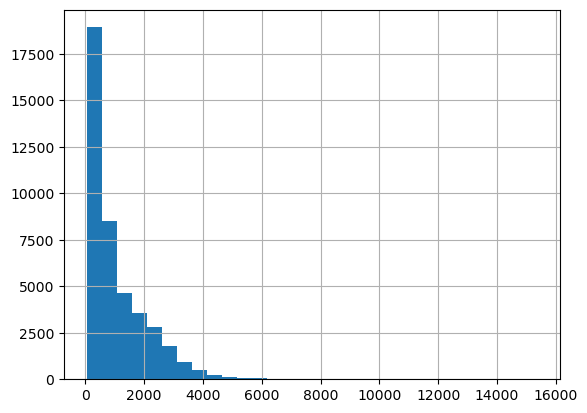

In [115]:
df_plot_summary['1'].str.len().hist(bins=30)

<Axes: >

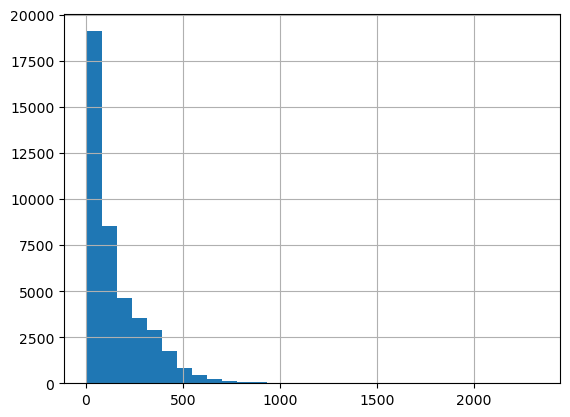

In [116]:
df_plot_summary['1'].str.split().map(lambda x: len(x)).hist(bins=30)

In [117]:
genre_df = df_movie_metadata[[0,2,8]]
genre_df['genre'] = genre_df[8].apply(lambda x: list(json.loads(x).values()))
genre_df['genre_id'] = genre_df[8].apply(lambda x: list(json.loads(x).keys()))

genre_df.columns = ['movie_id','title','genre_json','genre','genre_id']

#remove genre_json and genre_id
genre_df = genre_df.drop(columns=['genre_json','genre_id'])
genre_df.head()

C:\Users\Felix\AppData\Local\Temp\ipykernel_10680\1016515353.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_df['genre'] = genre_df[8].apply(lambda x: list(json.loads(x).values()))
C:\Users\Felix\AppData\Local\Temp\ipykernel_10680\1016515353.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_df['genre_id'] = genre_df[8].apply(lambda x: list(json.loads(x).keys()))


,movie_id,title,genre
0,975900,Ghosts of Mars,"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,Brun bitter,"[Crime Fiction, Drama]"
3,9363483,White Of The Eye,"[Thriller, Erotic thriller, Psychological thri..."
4,261236,A Woman in Flames,[Drama]


In [118]:
flattened_list = [item for sublist in genre_df['genre'] for item in sublist]

# Step 2: Count the occurrences of each element
element_counts = Counter(flattened_list)
print(len(element_counts))
sorted(element_counts.items(), key=lambda x:x[1], reverse=True)

363


[('Drama', 34007),
 ('Comedy', 16349),
 ('Romance Film', 10234),
 ('Black-and-white', 9094),
 ('Action', 8798),
 ('Thriller', 8744),
 ('Short Film', 8141),
 ('World cinema', 7155),
 ('Crime Fiction', 6948),
 ('Indie', 6897),
 ('Documentary', 5630),
 ('Horror', 5280),
 ('Silent film', 5250),
 ('Adventure', 4963),
 ('Family Film', 4598),
 ('Action/Adventure', 4561),
 ('Comedy film', 4362),
 ('Musical', 4160),
 ('Animation', 3534),
 ('Romantic drama', 3372),
 ('Mystery', 3195),
 ('Science Fiction', 3052),
 ('Fantasy', 2820),
 ('Romantic comedy', 2680),
 ('War film', 2652),
 ('Japanese Movies', 2322),
 ('Western', 2226),
 ('Crime Thriller', 2122),
 ('Period piece', 1758),
 ('Comedy-drama', 1720),
 ('Film adaptation', 1531),
 ('Chinese Movies', 1525),
 ('Biography', 1392),
 ('Psychological thriller', 1331),
 ('Bollywood', 1321),
 ('Sports', 1206),
 ('Biographical film', 1198),
 ('LGBT', 1163),
 ('Music', 1088),
 ('Family Drama', 1043),
 ('Black comedy', 1025),
 ('Parody', 999),
 ('Televisio

In [119]:
#remove all with <= 10 occurences -> reduce from 363 to 
element_counts = {k: v for k, v in element_counts.items() if v >= 10}
print(len(element_counts))
sorted(element_counts.items(), key=lambda x:x[1], reverse=True)


281


[('Drama', 34007),
 ('Comedy', 16349),
 ('Romance Film', 10234),
 ('Black-and-white', 9094),
 ('Action', 8798),
 ('Thriller', 8744),
 ('Short Film', 8141),
 ('World cinema', 7155),
 ('Crime Fiction', 6948),
 ('Indie', 6897),
 ('Documentary', 5630),
 ('Horror', 5280),
 ('Silent film', 5250),
 ('Adventure', 4963),
 ('Family Film', 4598),
 ('Action/Adventure', 4561),
 ('Comedy film', 4362),
 ('Musical', 4160),
 ('Animation', 3534),
 ('Romantic drama', 3372),
 ('Mystery', 3195),
 ('Science Fiction', 3052),
 ('Fantasy', 2820),
 ('Romantic comedy', 2680),
 ('War film', 2652),
 ('Japanese Movies', 2322),
 ('Western', 2226),
 ('Crime Thriller', 2122),
 ('Period piece', 1758),
 ('Comedy-drama', 1720),
 ('Film adaptation', 1531),
 ('Chinese Movies', 1525),
 ('Biography', 1392),
 ('Psychological thriller', 1331),
 ('Bollywood', 1321),
 ('Sports', 1206),
 ('Biographical film', 1198),
 ('LGBT', 1163),
 ('Music', 1088),
 ('Family Drama', 1043),
 ('Black comedy', 1025),
 ('Parody', 999),
 ('Televisio

In [120]:
for i in np.arange(0, len(genre_df)):
    genres = genre_df['genre'].iloc[i]
    if len(genres) > 0:
        counts = np.zeros(len(genres))
        idx = 0
        
        for genre in genres:
            counts[idx] = element_counts[genre]
            idx += 1

        print(genres[np.argmax(counts)])
    else:
        print('None')


Action
Drama
Drama
Thriller
Drama
Comedy
World cinema
Comedy
Drama
Horror
Drama
Thriller
Drama
Drama
Comedy
Action
Drama
Drama
None
Drama
Drama
Drama
Comedy
Drama
Drama
Short Film
Comedy
Romance Film
Drama
Drama
Comedy
Action
None
Thriller
Drama
Drama
Drama
Drama
Comedy
Drama
Black-and-white
Comedy
None
World cinema
Musical
Comedy
Short Film
Comedy
Drama
Comedy
None
Drama
Comedy
Drama
Action
Drama
Drama
Drama
Drama
Black-and-white
Drama
Comedy
Drama
Drama
Drama
Black-and-white
Drama
Black-and-white
Short Film
Documentary
Short Film
Drama
Horror
Action
Drama
Comedy
Comedy
Indie
Western
Bollywood
World cinema
Drama
Drama
Drama
Documentary
Short Film
Drama
Drama
Comedy
Drama
Romance Film
Documentary
Action/Adventure
Sexploitation
Silent film
Comedy
Horror
Documentary
Drama
Drama
None
Drama
Drama
Short Film
Drama
Drama
Drama
Drama
Drama
Short Film
Documentary
Drama
Thriller
Comedy film
Chinese Movies
Horror
Film noir
Comedy
Short Film
Comedy
Documentary
Horror


KeyError: 'Legal drama'

In [ ]:
# make a cooccurence matrix for the genres in genred_df column 'genre' and plot it
from itertools import combinations

# Create an empty co-occurrence matrix
# Create an empty co-occurrence matrix
genre_list = list(set(genre for sublist in genre_df['genre'] for genre in sublist))
co_occurrence_matrix = pd.DataFrame(0, columns=genre_list, index=genre_list)

# Iterate through rows and update the matrix
for genres in genre_df['genre']:
    for genre1, genre2 in combinations(genres, 2):
        co_occurrence_matrix.at[genre1, genre2] += 1
        co_occurrence_matrix.at[genre2, genre1] += 1
        
import numpy as np
# Set the diagonal to zero
np.fill_diagonal(co_occurrence_matrix.values, 0)
# remove the rows and columns with only zeros
co_occurrence_matrix = co_occurrence_matrix.loc[:, (co_occurrence_matrix != 0).any(axis=0)]
co_occurrence_matrix = co_occurrence_matrix.loc[(co_occurrence_matrix != 0).any(axis=1), :]
#sort columns by most occuring genre
co_occurrence_matrix = co_occurrence_matrix.sort_values(by=list(co_occurrence_matrix.columns), ascending=False)
#sort rows by most occuring genre
co_occurrence_matrix = co_occurrence_matrix.sort_values(by=list(co_occurrence_matrix.columns), ascending=False, axis=1)


# plot the co-occurrence matrix
import seaborn as sns
plt.figure(figsize=(15,10))
sns.heatmap(co_occurrence_matrix.iloc[:10,:10], cmap='Blues', annot=True, fmt='g')
plt.title('Co-occurrence matrix for the 10 most occuring genres')
plt.show()

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
# use preprocess function to preprocess genre_df['genre]
genre_df['genre'] = genre_df['genre'].apply(lambda x: [preprocess_text(genre) for genre in x])
#replace film, films, and movie, movies, cinema, 's with ""
genre_df['genre'] = genre_df['genre'].apply(lambda x: [re.sub(r'\b(film|films|movie|movies|cinema|\'s)\b', '', genre) for genre in x])
#remove trailing and leading spaces
genre_df['genre'] = genre_df['genre'].apply(lambda x: [genre.strip() for genre in x])

In [ ]:
#reduce categories
unique_categories = list(set([category for sublist in genre_df['genre'] for category in sublist]))

#remove empty strings
unique_categories = [category for category in unique_categories if category != '']

unique_categories


['serial',
 'school story',
 'ensemble',
 'interpersonal relationships',
 'supernatural',
 'indian western',
 'nuclear warfare',
 'japanese',
 'malayalam',
 'bruceploitation',
 'fantasy adventure',
 'camp',
 'british empire',
 'period piece',
 'erotica',
 'political thriller',
 'revisionist western',
 'parody',
 'feature',
 'horse racing',
 'romantic comedy',
 'vampire',
 'religious',
 'breakdance',
 'mockumentary',
 'social issues',
 'historical drama',
 'comedy western',
 'heist',
 'filmed play',
 'parkour in popular culture',
 'bloopers candid camera',
 'women in prison',
 'christian',
 'noir',
 'road',
 'legal drama',
 'star vehicle',
 'backstage musical',
 'travel',
 'tragedy',
 'libraries and librarians',
 'homoeroticism',
 'romantic drama',
 'buddy picture',
 'computer animation',
 'familyoriented adventure',
 'alien invasion',
 'splatter',
 'fantasy comedy',
 'law crime',
 'instrumental music',
 'martial arts',
 'political documetary',
 'mystery',
 'sponsored',
 'pornography',


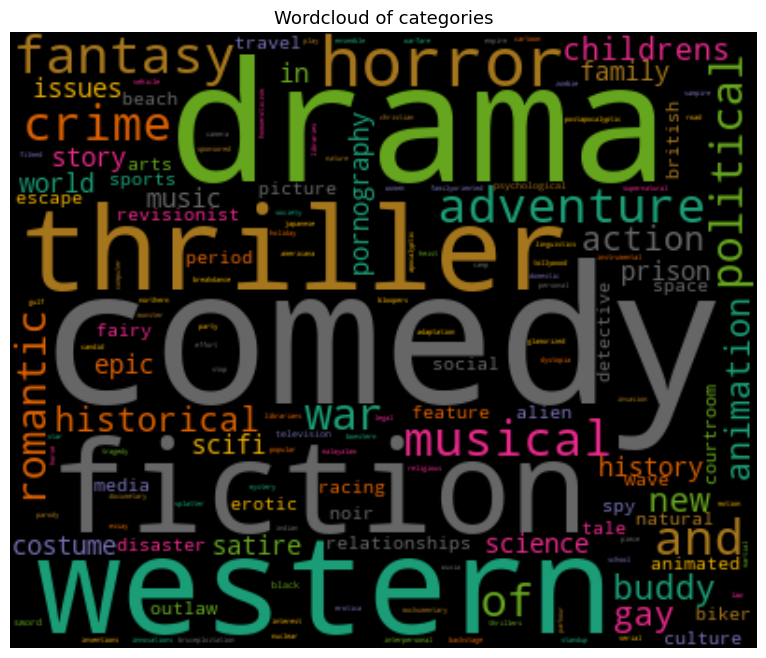

In [ ]:
#tokenize the categories
tokenized_categories = [category.split() for category in unique_categories]
#show word cloud of the categories
generate_wordcloud(Counter([word for sublist in tokenized_categories for word in sublist]), 'Wordcloud of categories')

In [ ]:
# from sentence_transformers import SentenceTransformer
# from sklearn.cluster import KMeans

# # Define the SBERT model (distilbert-base-uncased)
# model = SentenceTransformer('distilbert-base-uncased')

# # Extract category names
# category_names = [category for category in unique_categories]

# # Encode the category names into SBERT embeddings
# category_embeddings = model.encode(category_names, convert_to_tensor=True)

# # Perform K-means clustering with n clusters
# kmeans = KMeans(n_clusters=15)
# kmeans.fit(category_embeddings)

# # Get the cluster labels for each category
# cluster_labels = kmeans.labels_

# # Create a dictionary to group categories by their cluster label
# clusters = {}
# for i, label in enumerate(cluster_labels):
#     if label not in clusters:
#         clusters[label] = []
#     clusters[label].append(category_names[i])

# # Print the movie categories grouped by clusters
# for cluster_label, cluster_categories in clusters.items():
#     print(f"Cluster {cluster_label + 1}:")
#     print(", ".join(cluster_categories))
#     print()

# #Create a DataFrame from the 'clusters' dictionary
# df_clusters = pd.DataFrame.from_dict(clusters, orient='index')
# df_clusters = df_clusters.transpose()

# # Write the DataFrame to a CSV file with a semicolon (;) separator
# df_clusters.to_csv('Data/MovieSummaries/genre_clusters_embedding.csv', index=False, sep=';')

No sentence-transformers model found with name C:\Users\Felix/.cache\torch\sentence_transformers\distilbert-base-uncased. Creating a new one with MEAN pooling.
c:\anaconda3\envs\nlp-project\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\anaconda3\envs\nlp-project\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Cluster 9:
serial, ensemble, camp, feature, religious, road, travel, sponsored, nature, holiday, drama, news, history, animation, world, disaster, political, baseball, documentary, business, christmas, education, journalism, beach, biography, music, dance, race, sports, combat, action, anime, experimental, boxing, short, computers, educational, animals, television, musical, war, art, concert, archaeology

Cluster 2:
school story, breakdance, filmed play, star vehicle, backstage musical, buddy picture, law crime, inventions innovations, wuxia, tollywood, prison escape, dogme, buddy cop, space western, demonic child, master criminal, childrens, female buddy, filmopera, addiction drama, new queer, costume adventure, future noir, goat gland, ealing comedies, epic western, inspirational drama, stoner, singing cowboy, outlaw biker, new hollywood, neonoir, silhouette animation, mondo, acid western, animal picture, illnesses disabilities, finance investing, giallo, precode, heavenly comedy

Cl

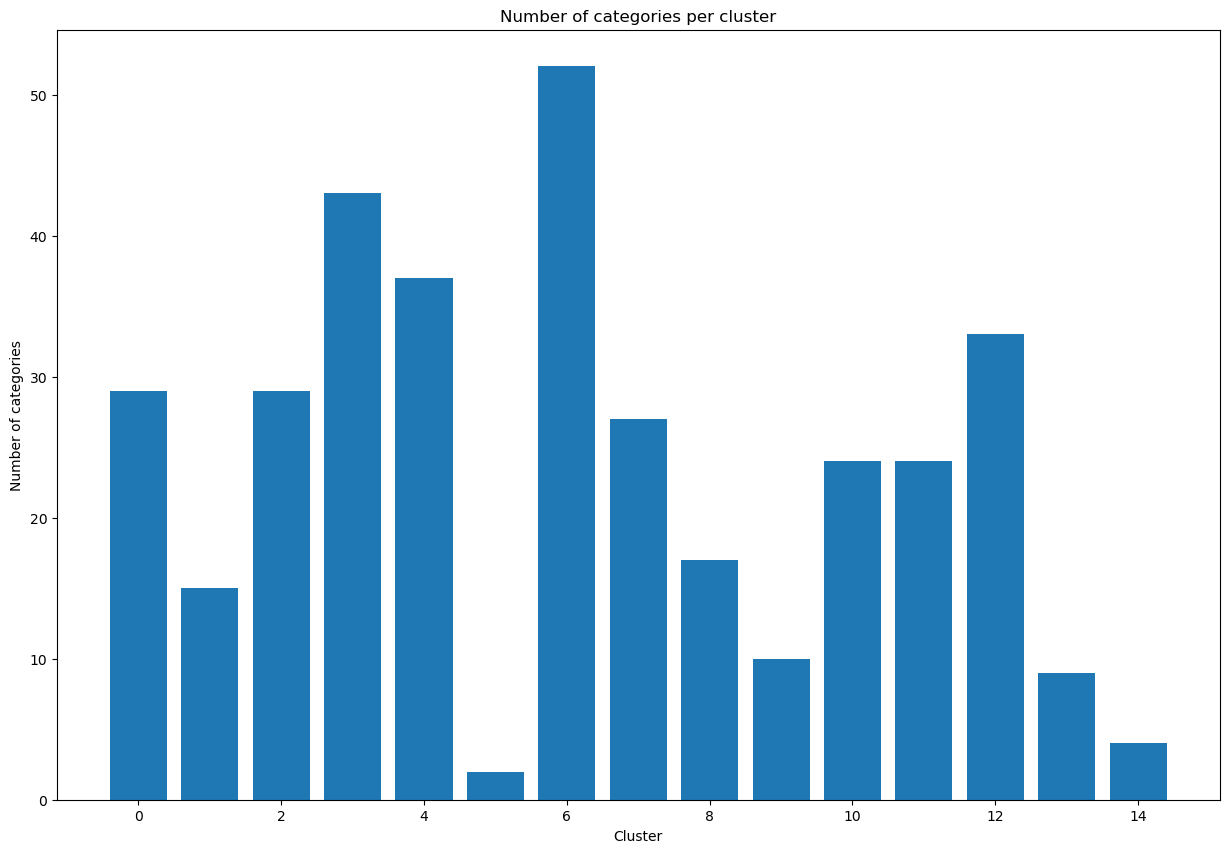

In [ ]:
#show balance of clusters
plt.figure(figsize=(15,10))
plt.bar(clusters.keys(), [len(cluster) for cluster in clusters.values()])
plt.title('Number of categories per cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of categories')
plt.show()

TF-IDF funktioniert deutlich besser als SentenceTransformer

In [ ]:
#clustering with TF-IDF (Term Frequency-Inverse Document Frequency) vectorization process in the provided code converts textual data (in this case, movie category names) into numerical vectors. 


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans


# Extract category names
category_names = [category for category in unique_categories]

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the category names using TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(category_names)

# Perform K-means clustering with n clusters
kmeans = KMeans(n_clusters=15)
kmeans.fit(tfidf_matrix)

# Get the cluster labels for each category
cluster_labels = kmeans.labels_

# Create a dictionary to group categories by their cluster label
clusters = {}
for i, label in enumerate(cluster_labels):
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(category_names[i])

# Print the movie categories grouped by "over genres"
for cluster_label, cluster_categories in clusters.items():
    print(f"Over Genre {cluster_label + 1}:")
    print(", ".join(cluster_categories))
    print()

c:\anaconda3\envs\nlp-project\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Over Genre 1:
serial, ensemble, interpersonal relationships, supernatural, indian western, nuclear warfare, japanese, malayalam, bruceploitation, camp, british empire, period piece, erotica, revisionist western, parody, feature, horse racing, vampire, religious, breakdance, mockumentary, social issues, heist, filmed play, parkour in popular culture, bloopers candid camera, christian, noir, road, star vehicle, backstage musical, travel, tragedy, homoeroticism, computer animation, alien invasion, splatter, instrumental music, martial arts, mystery, sponsored, pornography, inventions innovations, nature, dystopia, culture society, stop motion, wuxia, biker, holiday, essay, spy, bwestern, beach party, gay interest, zombie, family personal relationships, adaptation, tollywood, americana, glamorized spy, action thrillers, linguistics, monster, northern, animated cartoon, about gladiators, news, anthropology, health fitness, adult, indie, language literature, superhero, dogme, blaxploitation,

In [ ]:
# #Create a DataFrame from the 'clusters' dictionary
# df_clusters = pd.DataFrame.from_dict(clusters, orient='index')

# #sort by index desc
# df_clusters = df_clusters.sort_index(ascending=True)
# #transpose
# df_clusters = df_clusters.transpose()

# # Write the DataFrame to a CSV file with a semicolon (;) separator
# df_clusters.to_csv('Data/MovieSummaries/genre_clusters_tf-idf.csv', index=False, sep=';')

In [ ]:
#load the clusters from the csv file
df_clusters = pd.read_csv('Data/MovieSummaries/genre_clusters_tf-idf.csv', sep=';')

In [ ]:
#define names for the clusters according to the categories
# 0 = miscellaneous
# 1 = thriller
# 2 = buddy picture
# 3 = adventre

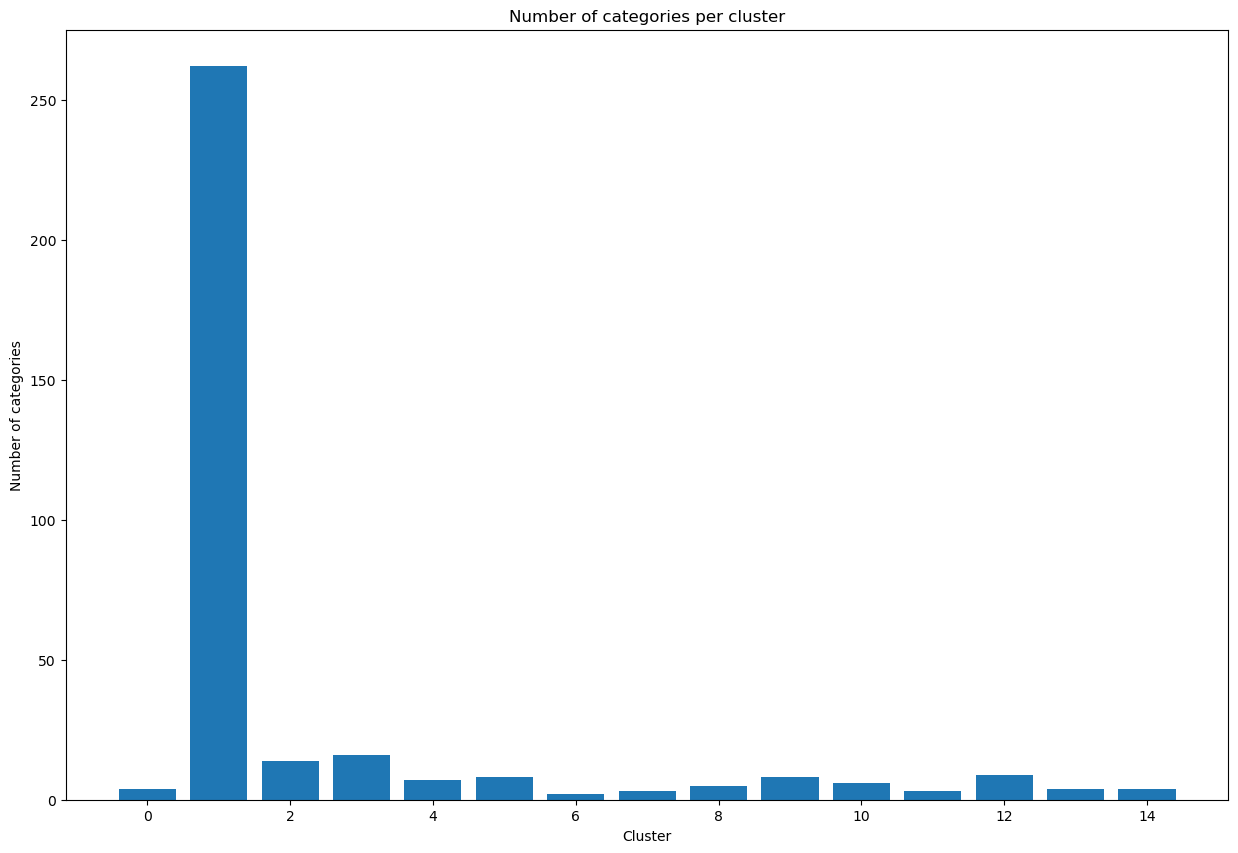

In [ ]:
#show balance of clusters
plt.figure(figsize=(15,10))
plt.bar(clusters.keys(), [len(cluster) for cluster in clusters.values()])
plt.title('Number of categories per cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of categories')
plt.show()

In [ ]:
# #do embedding with word2vec

# from gensim.models import Word2Vec
# import gensim.downloader as api
# from sklearn.cluster import KMeans
# import numpy as np


# # Load a pre-trained Word2Vec model (for example, using gensim)
# # Replace 'path_to_pretrained_model' with the actual path to your Word2Vec model file
# # if model does not exist, download 

# info = api.info()  # show info about available models/datasets
# word2vec_model = api.load("glove-wiki-gigaword-300")  # download the model and return as object ready for use

# # Create an average vector for each movie category
# category_vectors = []
# for category in unique_categories:
#     words = category.split()  # Split the category name into words
#     vectors = [word2vec_model[word] for word in words if word in word2vec_model]
#     if vectors:
#         category_vector = np.mean(vectors, axis=0)  # Compute the average vector
#         category_vectors.append(category_vector)

# # Convert the list of category vectors to a NumPy array
# X = np.array(category_vectors)

# # Perform K-means clustering with n clusters (adjust as needed)
# kmeans = KMeans(n_clusters=15)
# kmeans.fit(X)

# # Get the cluster labels for each category
# cluster_labels = kmeans.labels_

# # Create a dictionary to group categories by their cluster label
# clusters = {}
# for i, label in enumerate(cluster_labels):
#     if label not in clusters:
#         clusters[label] = []
#     clusters[label].append(unique_categories[i])

# # Print the movie categories grouped by clusters
# for cluster_label, cluster_categories in clusters.items():
#     print(f"Cluster {cluster_label + 1}:")
#     print(", ".join(cluster_categories))
#     print()


ModuleNotFoundError: No module named 'gensim'

In [ ]:
# use the clusters to reduce the categories
# Create a dictionary to map each category to its cluster label
category_to_cluster = {}
for cluster_label, cluster_categories in clusters.items():
    for category in cluster_categories:
        category_to_cluster[category] = cluster_label
        

category_to_cluster


{'': 1,
 'bruceploitation': 1,
 'mumblecore': 1,
 'alien invasion': 1,
 'cavalry': 1,
 'about gladiators': 1,
 'tamil': 1,
 'neorealism': 1,
 'existentialism': 1,
 'swashbuckler': 1,
 'superhero': 1,
 'stop motion': 1,
 'music': 1,
 'supernatural': 1,
 'precode': 1,
 'exploitation': 1,
 'filmed play': 1,
 'bmovie': 1,
 'dance': 1,
 'clay animation': 1,
 'finance investing': 1,
 'plague': 1,
 'period piece': 1,
 'nature': 1,
 'filmopera': 1,
 'breakdance': 1,
 'language literature': 1,
 'mystery': 1,
 'gay pornography': 1,
 'patriotic': 1,
 'sword and sandal': 1,
 'tollywood': 1,
 'jungle': 1,
 'caper story': 1,
 'goat gland': 1,
 'samurai': 1,
 'grossout': 1,
 'softcore porn': 1,
 'combat': 1,
 'cold war': 1,
 'homoeroticism': 1,
 'linguistics': 1,
 'albino bias': 1,
 'teen': 1,
 'roadhorror': 1,
 'revisionist fairy tale': 1,
 'escape': 1,
 'war': 1,
 'chinese': 1,
 'auto racing': 1,
 'anthropology': 1,
 'biographical': 1,
 'monster': 1,
 'new hollywood': 1,
 'historical epic': 1,
 'se

In [ ]:
# Create 13 empty columns for the clusters
for i in range(15):
    genre_df[i] = 0
    
# Iterate through rows and update the cluster columns
for i, row in genre_df.iterrows():
    for category in row['genre']:
        genre_df.at[i, category_to_cluster[category]] = 1
        
genre_df.head()

,movie_id,title,genre,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,975900,Ghosts of Mars,"[thriller, science fiction, horror, adventure,...",1,1,0,0,0,1,0,0,1,0,0,0,0,0,1
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,"[mystery, biographical, drama, crime drama]",0,1,0,1,1,0,0,0,0,0,0,0,0,0,0
2,28463795,Brun bitter,"[crime fiction, drama]",0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
3,9363483,White Of The Eye,"[thriller, erotic thriller, psychological thri...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,261236,A Woman in Flames,[drama],0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
# count occurences of genres in columsn 0-14
genre_df[range(15)].sum().sort_values(ascending=False)


1     60668
4     34634
2     21148
14     9463
3      8122
8      5310
12     4290
5      4076
10     3030
0      2296
11     1918
13      757
7       503
9       140
6        73
dtype: int64

In [ ]:
# Step 1: Create a list of all unique genre labels
# if 1 is in column 0-14, replace with the column name
genre_df['genre_hm'] = genre_df[range(15)].apply(lambda x: [x.index[i] for i in range(len(x)) if x[i]==1], axis=1)

# Step 2: Create an empty co-occurrence matrix
co_occurrence_matrix = pd.DataFrame(0, columns=genre_df['genre_hm'], index=genre_df['genre_hm'])

# Step 3: Iterate through rows and update the matrix
for genres_str in genre_df['genre_hm']:
    genres = [int(genre) for genre in genres_str.strip('[]').split(',')]
    for genre1, genre2 in combinations(genres, 2):
        co_occurrence_matrix.at[genre1, genre2] += 1
        co_occurrence_matrix.at[genre2, genre1] += 1

# Set the diagonal to zero
np.fill_diagonal(co_occurrence_matrix.values, 0)

# Remove the rows and columns with only zeros
co_occurrence_matrix = co_occurrence_matrix.loc[:, (co_occurrence_matrix != 0).any(axis=0)]
co_occurrence_matrix = co_occurrence_matrix.loc[(co_occurrence_matrix != 0).any(axis=1), :]

# Sort columns by most occurring genre
co_occurrence_matrix = co_occurrence_matrix.sort_values(by=list(co_occurrence_matrix.columns), ascending=False)

# Sort rows by most occurring genre
co_occurrence_matrix = co_occurrence_matrix.sort_values(by=list(co_occurrence_matrix.columns), ascending=False, axis=1)

# Plot the co-occurrence matrix
plt.figure(figsize=(15, 10))
sns.heatmap(co_occurrence_matrix.iloc[:10, :10], cmap='Blues', annot=True, fmt='g')
plt.title('Co-occurrence matrix for the 10 most occurring genres')
plt.show()

AttributeError: 'list' object has no attribute 'strip'